In [70]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Sentiment Analysis
We will use the IMDB sentiment analysis database in this tutorial. The main idea that is used in this tutorial is that certain words are enough to establish the sentiment of a given sentence. The word order is discarded in this particular tutorial.
<img src="./images/angry_happy_dogo.png" alt="dogo" style="width: 500px;"/>

## References
1. http://ai.stanford.edu/~amaas/data/sentiment/

In [0]:
import numpy as np
import pandas as pd
import os
import urllib

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

In [72]:
!pwd

/content


In [73]:
!ls -l

total 12356
drwxr-xr-x 2 root root    4096 Mar  8 13:08 data
drwxr-xr-x 1 root root    4096 Mar  8 12:32 datalab
-rw-r--r-- 1 root root 1035584 Mar  8 13:03 my_model.h5
-rw-r--r-- 1 root root 1648877 Mar  8 13:02 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    4542 Mar  8 13:02 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9912422 Mar  8 13:02 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root   28881 Mar  8 13:02 train-labels-idx1-ubyte.gz


In [74]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [75]:
!ls -l data

total 33004
-rw-r--r-- 1 root root 33795881 Mar  8 13:08 reviews2.pkl


In [76]:
if not os.path.isfile('data/reviews2.pkl'):
    urllib.request.urlretrieve('https://www.dropbox.com/s/15tfttuzqe7fimg/reviews2.pkl?dl=1','./data/reviews2.pkl')
    
df = pd.read_pickle('data/reviews2.pkl')    
df.head()

,Reviews,Sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [77]:
df.Reviews.values[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [78]:
df.shape

(25000, 2)

In the first model that we look at we simply count the number of words in each document. This method is called **Bag of words**. It's considered a bag since we lose all ordering of the words. The features are simply the count of each word. 

Lucky for us Scikit Learn contains this feature extractor as a method. See http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage for an example. the `fit_transform` method gives us the matrix that we are after.

In [0]:
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(df.Reviews.values)

In [80]:
print('Number of unique words: ',len(tf_vectorizer.get_feature_names()))
print(tf_vectorizer.get_feature_names()[:5])

Number of unique words:  74849
['00', '000', '0000000000001', '00001', '00015']


Unfortunately this is extremely noisy as can be seen by the existence of random numbers such as `00` etc. Hence we will do two additional things. We will only consider words that have appeared atleast 5 times. Also words such as `the, a, to` are irrelevant in figuring out what the sentiment is. Hence we shall remove such words. These are commonly known as _stop words_ in Natural Language Processing (NLP).

In [81]:
tf_vectorizer = CountVectorizer(min_df=5,stop_words='english')
tf = tf_vectorizer.fit_transform(df.Reviews.values)
print('New number of unique words: ',len(tf_vectorizer.get_feature_names()))

New number of unique words:  26967


Notice that tf is a sparse matrix

In [82]:
print(type(tf))
tf.shape

<class 'scipy.sparse.csr.csr_matrix'>


(25000, 26967)

We will use `np.random.permutation` to shuffle the data. It is really important to shuffle the data before we put it into any machine learning algorithm. See below as to how `np.random.permutation` works.

In [83]:
np.random.permutation(5)

array([2, 1, 4, 0, 3])

In [0]:
idx = np.random.permutation(len(df))
X_train = tf[idx][:12500].todense()
X_test = tf[idx][12500:].todense()
y_train = df.Sentiment.values[idx][:12500]
y_test = df.Sentiment.values[idx][12500:]

In [85]:
X_train.shape

(12500, 26967)

# Keras Model
Below we create our first deep learning model.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2, l1

In [87]:
model = Sequential()
model.add(Dense(units=100, input_dim=tf.shape[1]))
model.add(Activation("relu"))
model.add(Dense(units=1))
model.add(Activation("sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=["binary_accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               2696800   
_________________________________________________________________
activation_9 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0         
Total params: 2,696,901
Trainable params: 2,696,901
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.fit(X_train, y_train, epochs=2, batch_size=128)

Epoch 1/2
12500/12500 [==============================] - 2s 195us/step - loss: 0.3657 - binary_accuracy: 0.8482
Epoch 2/2
12500/12500 [==============================] - 2s 181us/step - loss: 0.1132 - binary_accuracy: 0.9661


Keras has two ways of predicting `model.predict(...)` which predicts the **probability** of belonging to a class (basically the value it gets after passing through final activation), and `model.predict_class(...)` which as the name suggests outputs the class. Here we will use the `predict` method.

**This is the probability of the class being 1 (positive review in this case).**

In [0]:
y_test_pred = model.predict(X_test)

In [90]:
print(y_test_pred.shape)
y_test_pred

(12500, 1)


array([[8.1114732e-03],
       [1.7962391e-02],
       [2.4983751e-02],
       ...,
       [9.8951018e-01],
       [9.5832676e-01],
       [2.3139123e-07]], dtype=float32)

Let us manually convert this to 0 or 1 class. Using numpy arrays

In [91]:
y_test_pred[y_test_pred<0.5] = 0
y_test_pred[y_test_pred>=0.5] = 1
np.count_nonzero(y_test_pred==y_test[:,None])*1.0/len(y_test)

0.88256

Let us test some manual test cases. Fee free to change the sentence below. Really important to note that I am using `transform` and not `fit_transform` below.

In [92]:
test_case = tf_vectorizer.transform(["I really hated this movie"])
model.predict(test_case.todense())

array([[0.38963157]], dtype=float32)

In [93]:
test_case = tf_vectorizer.transform(["I really loved this movie"])
model.predict(test_case.todense())

array([[0.6741574]], dtype=float32)

### Improving the model

Counting is one of the most basic things you could do when it comes to NLP applications. A more popular method that tends to be a bit better is Term Frequency - inverse Document Frequency (Tfidf) method. Not only does it take frequncy (term frequency) into account, but it also penalises words for being overused (for example the word 'the' would be downvoted since it is too popular). The intuition being that it does not have any discriminatory power if the word is used in every sentence. Whereas rare words might be able to distinguish the contents of the sentence better.

In [0]:
tfidf_vectorizer = TfidfVectorizer(min_df=5,stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df.Reviews.values)

# get the new features
X_train = tfidf[idx][:12500].todense()
X_test = tfidf[idx][12500:].todense()

In [95]:
model = Sequential()
model.add(Dense(units=100, input_dim=tf.shape[1]))
model.add(Activation("relu"))
model.add(Dense(units=1))
model.add(Activation("sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=["binary_accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               2696800   
_________________________________________________________________
activation_11 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_12 (Activation)   (None, 1)                 0         
Total params: 2,696,901
Trainable params: 2,696,901
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.fit(X_train, y_train, epochs=2, batch_size=128)

Epoch 1/2
12500/12500 [==============================] - 2s 194us/step - loss: 0.3992 - binary_accuracy: 0.8519
Epoch 2/2
12500/12500 [==============================] - 2s 178us/step - loss: 0.1775 - binary_accuracy: 0.9536


In [97]:
y_test_pred = model.predict(X_test)
y_test_pred[y_test_pred<0.5] = 0
y_test_pred[y_test_pred>=0.5] = 1
np.count_nonzero(y_test_pred==y_test[:,None])/len(y_test)

0.88664

As can be seen the model is much better with our test data as seen below

In [98]:
test_case = tf_vectorizer.transform(["I really hated this movie"])
model.predict(test_case.todense())

array([[0.08817737]], dtype=float32)

In [99]:
test_case = tf_vectorizer.transform(["I really loved this movie"])
model.predict(test_case.todense())

array([[0.9919264]], dtype=float32)

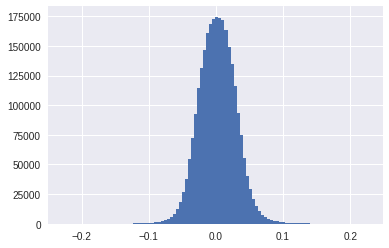

In [100]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

In [101]:
model.weights

[<tf.Variable 'dense_11/kernel:0' shape=(26967, 100) dtype=float32_ref>,
 <tf.Variable 'dense_11/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense_12/kernel:0' shape=(100, 1) dtype=float32_ref>,
 <tf.Variable 'dense_12/bias:0' shape=(1,) dtype=float32_ref>]